# Solución al ejercicio del tutorial de estimación de distancias

Using the simulated parallaxes from tutorial 1 generate distance estimations with the different methods (including the inverse of the parallax) and compare the results with the real distances from the simulation. Plot the comparisons and draw conclusions from them.

Using this query to join GUMS and GOG as a proxy for the simulated file

    select U.source_id, U.barycentric_distance, S.parallax, S.parallax_error
    from gaiaedr3.gaia_universe_model as U
    JOIN gaiaedr3.gaia_source_simulation as S
    using (source_id)
    WHERE U.ra>1 and U.ra<4 and U.dec>0.1 and U.dec<0.3
    
Result stored as _GUMS-GOG.csv_ (1317 objects)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from pyrallaxes import *

### Lectura del fichero de datos

In [2]:
data = pd.read_csv('GUMS-GOG.csv')

distance= data['barycentric_distance'].values/1000 # en kpc
parallax = data['parallax'].values # en mas
parallax_error= data['parallax_error'].values # en mas

### Estimación de distancia como $r=1/\varpi$

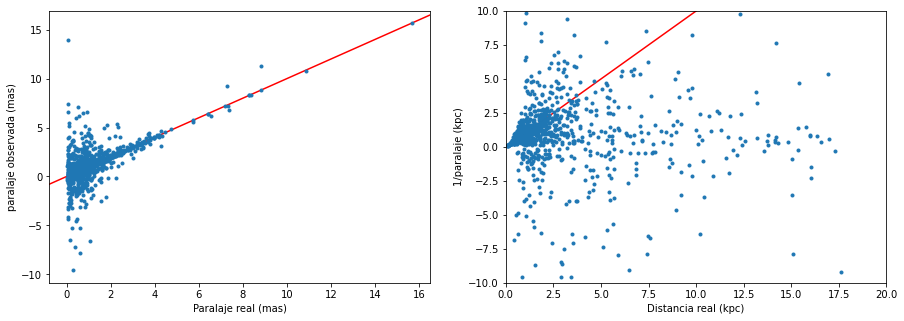

In [3]:
plt.rcParams["figure.figsize"] = (15,5)

plt.subplot(1,2,1)
plt.xlabel("Paralaje real (mas)")
plt.ylabel("paralaje observada (mas)")
plt.axline((0, 0), (0.02, 0.02),color="red")
plt.plot(1./distance,parallax,".")

plt.subplot(1,2,2)
plt.xlabel("Distancia real (kpc)")
plt.ylabel("1/paralaje (kpc)")
plt.xlim([0, 20]) # Limitamos el rango horizontal para centrarnos en la region principal
plt.ylim([-10, 10]) # Limitamos el rango vertical para centrarnos en la region principal
plt.axline((0, 0), (10, 10),color="red")
plt.plot(distance,1./parallax,".")

plt.show()

### Estimación de distancia usando el  "Exponentially Decreasing Space Density Prior"

La estimación es lenta, puede tardar un poco. 

In [4]:
# Parámetros del estimador
L = 1.35 #kpc
r_lim = 100 #kpc
r0 = 0.01 #kpc
beta = 1.01

p_inf = 0.05 # Normalized inferior percentile
p_sup = 0.95 # Normalized superior percentile

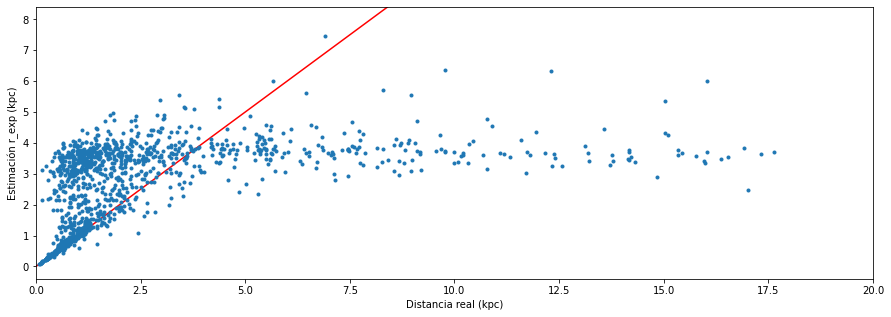

In [5]:
r_media_exp= []

for w,s in zip(parallax,parallax_error):
    
    # Cálculo de la moda de la PDF
    r_mode_exp = mode_r_exponential(L, w, s)

    p_exp = percentiles(exponentially_decreasing_space_density_posterior,r0,r_mode_exp,w,s,L)# Computing the percentile that corresponds to the mode of the PDF
    n_exp = normalization(exponentially_decreasing_space_density_posterior,L,w,s,p_exp,r_mode_exp,r_lim)# Computing the normalization constant of the PDF
    p_exp = normalized_percentile(p_exp,n_exp) # Normalized percentile. The percentile now ranges from 0 to 1.

    # Cálculo de la mediana de la PDF, usando como referencia la moda y su percentil asociado (esto acelera el cálculo)         
    r_media_exp.append( median(exponentially_decreasing_space_density_posterior,w,s,L,r_lim,r_mode_exp,p_exp,n_exp) )

    
plt.xlabel("Distancia real (kpc)")
plt.ylabel("Estimación r_exp (kpc)")
plt.xlim([0, 20]) # Limitamos el rango horizontal para centrarnos en la region principal
plt.axline((0, 0), (8, 8),color="red")
plt.plot(distance,r_media_exp,".")

plt.show()